In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from plot_drift import plot_drift
from plot_trajectory import plot_trajectory

In [4]:
#!./run.sh
output_dir = "output/dust_diffusion/"

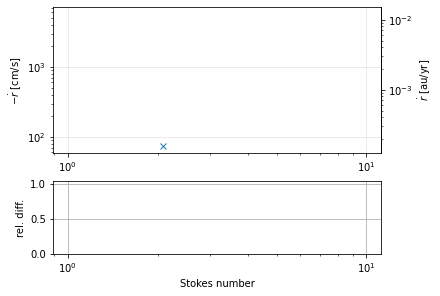

In [5]:
plot_drift(output_dir);

dr/dt -0.00011072804648472712


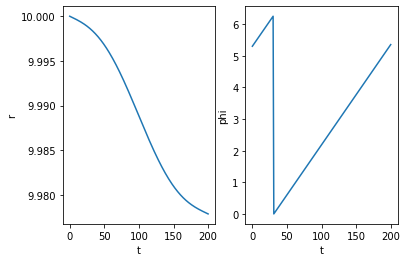

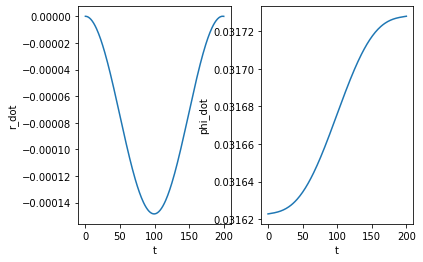

In [31]:
from load_dust import construct_dust_trajectories, get_output_times
particles = construct_dust_trajectories(output_dir, units=False)
r = np.array(particles[0]["r"])
t = np.array(get_output_times(output_dir, units=False))


print("dr/dt", (r[-1]-r[0])/(t[-1] - t[0]))
# plot_trajectory(output_dir, plotargs={"ls":"none", "marker":"x"});


def plot_two(a,b):
    fig, axes = plt.subplots(ncols=2)    

    ax = axes[0]
    ax.plot(t, particles[0][a])
    ax.set_xlabel("t")
    ax.set_ylabel(a)

    ax = axes[1]
    ax.plot(t, particles[0][b])
    ax.set_xlabel("t")
    ax.set_ylabel(b)

plot_two("r", "phi")
plot_two("r_dot", "phi_dot")

Text(0, 0.5, '1e5*dr/dt')

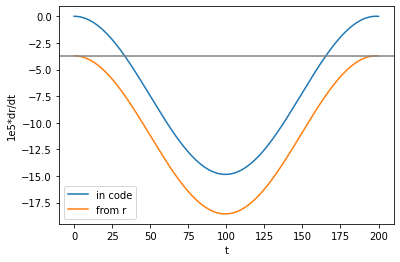

In [32]:
fig, ax = plt.subplots()
ax.plot(t, 1e5*particles[0]["r_dot"], label="in code")
ax.plot(0.5*(t[1:] + t[:-1]), 1e5*(r[1:] - r[:-1])/(t[1:] - t[:-1]), label="from r")
ax.legend()

ax.axhline(-3.7111153967326794e-05*1e5, color="grey")

ax.set_xlabel("t")
ax.set_ylabel("1e5*dr/dt")


In [67]:
import disgrid
d = disgrid.Data(output_dir)
p = d.get(var="x", planet=0)

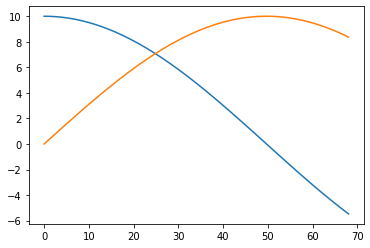

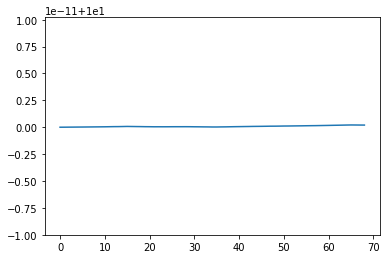

In [69]:
x = d.get(var="x", planet=1)
y = d.get(var="y", planet=1)

fig, ax = plt.subplots()
ax.plot(x.time, x.data)
ax.plot(y.time, y.data)

fig, ax = plt.subplots()
ax.plot(x.time, np.sqrt(x.data**2 + y.data**2))

In [6]:
def calc_stokes(size, particle_density, surface_density):
    return np.pi*size*particle_density / (2*surface_density)

In [7]:
import astropy.units as u
calc_stokes(1e-4*u.cm, 2.65*u.g/u.cm**3, 10*u.g/u.cm**2)

<Quantity 4.16261027e-05>

In [8]:
calc_stokes(100*u.cm, 2.65*u.g/u.cm**3, 10*u.g/u.cm**2)

<Quantity 41.62610266>

Stokes number calculation is correct in the FARGO code in case of Epstein drag only

In [9]:
4.16/1.51

2.7549668874172184

In [10]:
1/np.sqrt(1.4)

0.8451542547285166

In [11]:
1/1.4

0.7142857142857143

In [12]:
import astropy.units as u
import astropy.constants as const

Gas density in cgs

In [13]:
rhog = (10*u.g/u.cm**2 / (np.sqrt(2*np.pi) * 0.05* 1 * u.au)).to("g/cm3")
rhog

<Quantity 5.33352886e-12 g / cm3>

mean free path according to HB03 https://iopscience.iop.org/article/10.1086/345472/pdf eq 20
l (cm) = 4.72e-9 / (rho_g / (g/cm3)) cm

In [14]:
l = 4.72e-9 *u.cm / rhog.to_value("g/cm3")
l

<Quantity 884.96755595 cm>

For a s = 1e-4 cm particle

In [15]:
f = (1e-4*u.cm) / (1e-4*u.cm + l)
f

<Quantity 1.1299848e-07>

In [16]:
m0 = 2.35*u.u
temperature = 626.9*u.K
vthermal = np.sqrt(8 * const.k_B * temperature / (np.pi*m0))

In [17]:
vthermal.decompose()

<Quantity 2376.57953771 m / s>

In [18]:
np.sqrt(8/np.pi)*0.05

0.07978845608028655

in the code at r=1, vthermal = 0.07979 calcualting from temperature

In [19]:
np.sqrt(8/np.pi)*0.05

0.07978845608028655

In Picogna et al 2015, Fig. C2 shows the theoretical drift rate for a particle of stokes number  7.4e-4, which is roughly 5e-6 in the units shown.
The axis is labeled as cm/s, however, the order of magnitude fits for au/yr

In [20]:
sigmaslope = -1
temperatureslope = -1
Mstar = 0.05*u.solMass
h = 0.05
r = 1*u.au
stokes = 7.4e-4
vK = np.sqrt(const.G*Mstar/r).decompose()
eta = h**2 * (sigmaslope + temperatureslope)
vdrift = eta*vK/(stokes + stokes**-1)
vdrift.to("au/yr")

<Quantity -5.19826188e-06 AU / yr>

In [21]:
vK

<Quantity 6660.059562 m / s>

In [22]:
np.sqrt(8/np.pi)*0.05*vK

<Quantity 531.39586986 m / s>

In [23]:
885/1e-4/2

4425000.0

In [24]:
10*(1*u.au).to_value("cm")

149597870700000.0

In [25]:
import numpy as np
import astropy.units as u
import astropy.constants as const
from drift_theo import vdrift_theo
vdrift_theo(7.4e-4, 1*u.au, Mstar=0.55*u.solMass, h=0.05).to("au/yr")

<Quantity -1.72406842e-05 AU / yr>

In [26]:
from load_dust import construct_dust_trajectories
import matplotlib.pyplot as plt
import numpy as np

p = construct_dust_trajectories("output/dust_drift/")[0]

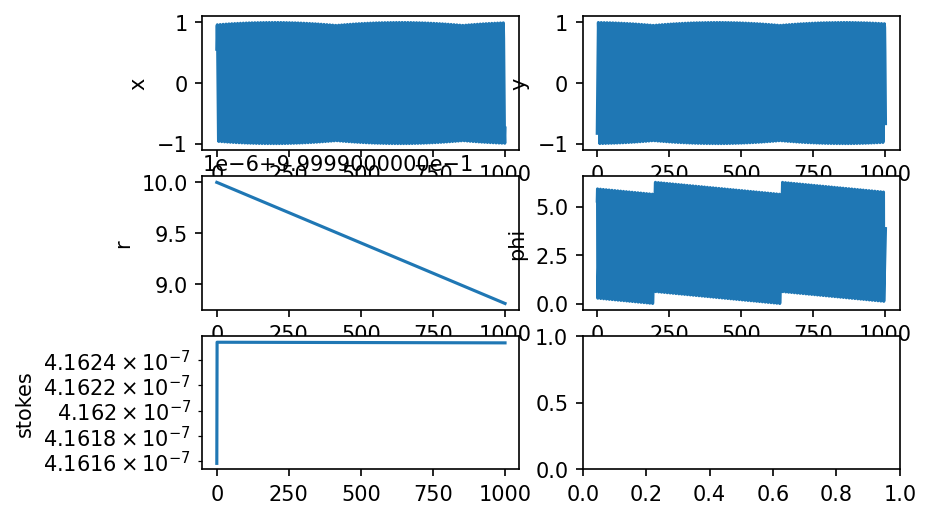

In [27]:
fig, axes = plt.subplots(ncols=2, nrows=3, dpi=150)

for ax, name in zip(axes.ravel(), ["x", "y", "r", "phi", "stokes"]):
    ax.plot(p[name])
    ax.set_ylabel(name)
    
axes[2,0].set_yscale("log")